# Case Study Part 2

## Todos

- ~~Write Introduction~~
- ~~Write Data formats~~
- ~~Load data~~ 
- ~~Write function to print validation images~~
- ~~Write function to add found boundaries to images~~
- Find a prelearned convnet for sattelite images
- Load it
- Fix the weights
- Train the head (softmax, 5 output neurons)
- Unfix the weights
- Train the whole classifier
- Write function to create predictions
<br>

**Ideas**
- Data Augmentation: Shifting, rotating and so on to increase amount of training data

## Introduction

For one of their projects an insurance company wants to get an estimate of the assets of their clients. For this they want to scan satellite images for four different objects: ponds, pools, photovoltaic systems and trampolines.

### Available data
To solve the task the following data are available.

**Training data**
<br>
The training data consist of five different groups. In the beginning the data themselves are not labels (as in labeled and already in a dataframe form). They are just .png and .jpg files in different subfolders. All training images are of size 256x256 pixels. The following five groups are available:
- Trampoline images: 140 images that contain a trampoline.
- Pond images: 9 images that contain a pond.
- Pool images: 20 images that contain a pool.
- Solar images: 37 images that contain a photovoltaic system.
- Background images: 3110 images that do not contain any of the above-mentioned items.

This sums up to 3316 labeled training patches. 

<br>

**Unlabeled training data**
<br>
In addition to the training patches, 20 validation images are available. They are of size 8000x8000 each and can be used for the manual validation of an approach.

<br>

**Validation data**
<br>
The validation data set contains 3 images of size 8000x8000. In addition there is a csv file that contains the coordinates of an item and a surrounding bounding box of various items and their respective labels.
Thus, one prediction should have the following shape (1,7) with column 1 as strings and the rest as integer values:
|label|y_target|x_target|y_upper_left|x_upper_left|y_lower_right|x_lower_right
|---|---|---|---|---|---|---|
|trampoline|268|278|140|150|396|406|
|...|

<br>

**Predictions** <br>
A prediction should represent a bounding box around a target entity. One prediction consist of the label and the four coordinates that describe the bounding box. <br>
<span style="color:red">The bounding box must be of size 256 x 256</span>. <br>
A prediction is considered correct if the predicted bounding box overlaps at least 50% with the ground truth bounding box. <br>
This overlap is computed as the area of the intersection of the boxes divided by the union of the areas of the boxes: IoU = intersection_area / union_area:

<img src="https://www.baeldung.com/wp-content/uploads/sites/4/2022/04/fig1.png" alt="Intersection over Union for Object Detection | Baeldung on Computer Science">

Our predictions thus must each be of shape (1,5):
|label|y_upper_left|x_upper_left|y_lower_right|x_lower_right
|---|---|---|---|---|
|trampoline|140|150|396|406|
|...|


## Data retrieval

This section loads the training patches into a numpy array and creates the corresponding label vector.
The result are X_train, X_val, y_train and y_val. 

The images are converted to RGB values, which is why there are 3 channels in the training data.

The training data sets are of dimension (number_of_instances x height x width x 3 channels). 
The label vectors only have one dimension (number_of_instances).

In [84]:
from PIL import Image
import numpy as np
import os

In [85]:
def loadImagesToArray(path:str):
    '''
    Loads all .jpg and .png files from the specified directory.\n
    Each image will be converted into an array of size (height x width x channels).\n
    The return numpy array is of dimensions (numberOfImages x height x width x channels).\n
    '''
    imagesArray = []

    counter = 0
    for file in os.scandir(path):
        filepath = os.fsdecode(file)
        if(filepath.endswith(".jpg") or filepath.endswith(".png")):
                imgArray = np.array(Image.open(filepath))
                imagesArray.append(imgArray)
                counter += 1                  
    return np.array(imagesArray)

def loadTrainingDataAndLabels(path:str, subdirectories: list[str]):
    '''
    Loads the training data as numpy arrays and creates the corresponding labels.\n
    For this to work, the images should be under the folder <path> in separate subdirectories, one for each class.\n
    The labels will be inferred from the names of the subdirectories. \n

    Returns the training data as a numpy array with the dimensions (number_of_images x height x width x channels).\n
    Returns the labels as a numpy array with the dimensions (number_of_images).
    '''

    training_data = []
    labels = []

    for directory in subdirectories:
        images_array = loadImagesToArray(os.path.join(path, directory))
        training_data.extend(images_array)

        labels.extend(np.full(len(images_array), directory))

    training_data_array = np.array(training_data)
    print("Shape of training_data: ", training_data_array.shape)
    labels_array = np.array(labels)
    print("Shape of labels: ", labels_array.shape)
    
    return training_data_array, labels_array

In [86]:
training_data, labels = loadTrainingDataAndLabels("data/training_patches/", ["background", "ponds", "pools", "solar", "trampoline"])

Shape of training_data:  (3316, 256, 256, 3)
Shape of labels:  (3316,)


In [87]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(training_data, labels, test_size=0.33, random_state=1, stratify=labels)

In [88]:
print("Shape of X_train: ", X_train.shape)
print("Shape of y_train: ", y_train.shape)
print("Shape of X_val: ", X_val.shape)
print("Shape of y_val: ", y_val.shape)

Shape of X_train:  (2221, 256, 256, 3)
Shape of y_train:  (2221,)
Shape of X_val:  (1095, 256, 256, 3)
Shape of y_val:  (1095,)


## Data Augmentation

## Model Selection

### Feature Extraction with ConvNet

In [89]:
from tensorflow import keras
import numpy as np

In [90]:
base_model = keras.applications.InceptionV3(weights="imagenet", include_top=False, pooling="avg", input_shape=(256, 256, 3))

model=keras.models.Sequential()
model.add(base_model)
model.add(keras.layers.Flatten())
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(256, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(5, activation='softmax'))


for layer in base_model.layers:
    layer.trainable = False

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 2048)              21802784  
_________________________________________________________________
flatten_5 (Flatten)          (None, 2048)              0         
_________________________________________________________________
batch_normalization_678 (Bat (None, 2048)              8192      
_________________________________________________________________
dense_20 (Dense)             (None, 256)               524544    
_________________________________________________________________
dropout_15 (Dropout)         (None, 256)               0         
_________________________________________________________________
batch_normalization_679 (Bat (None, 256)               1024      
_________________________________________________________________
dense_21 (Dense)             (None, 128)              

In [91]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 2048)              21802784  
_________________________________________________________________
flatten_5 (Flatten)          (None, 2048)              0         
_________________________________________________________________
batch_normalization_678 (Bat (None, 2048)              8192      
_________________________________________________________________
dense_20 (Dense)             (None, 256)               524544    
_________________________________________________________________
dropout_15 (Dropout)         (None, 256)               0         
_________________________________________________________________
batch_normalization_679 (Bat (None, 256)               1024      
_________________________________________________________________
dense_21 (Dense)             (None, 128)              

In [92]:
from keras.applications.inception_v3 import preprocess_input

X_train_preprocessed = preprocess_input(np.copy(X_train))
X_val_preprocessed = preprocess_input(np.copy(X_val))

# One-Hot Encoding y_train
y_train_encoded = pd.get_dummies(y_train)
y_train_encoded.shape

(2221, 5)

In [93]:
history = model.fit(X_train_preprocessed, 
                    y_train_encoded, 
                    epochs=10,
                    batch_size=32,
                    validation_split=0.1
                   )

Epoch 1/10
63/63 [==============================] - 9s 98ms/step - loss: 1.8425 - accuracy: 0.2968 - val_loss: 0.8527 - val_accuracy: 0.8924
Epoch 2/10
63/63 [==============================] - 5s 83ms/step - loss: 1.1798 - accuracy: 0.5696 - val_loss: 0.5590 - val_accuracy: 0.9327
Epoch 3/10
63/63 [==============================] - 5s 81ms/step - loss: 0.7014 - accuracy: 0.8013 - val_loss: 0.3324 - val_accuracy: 0.9372
Epoch 4/10
63/63 [==============================] - 5s 80ms/step - loss: 0.4245 - accuracy: 0.8944 - val_loss: 0.2608 - val_accuracy: 0.9417
Epoch 5/10
63/63 [==============================] - 5s 80ms/step - loss: 0.3078 - accuracy: 0.9344 - val_loss: 0.2545 - val_accuracy: 0.9462
Epoch 6/10
63/63 [==============================] - 5s 81ms/step - loss: 0.2563 - accuracy: 0.9419 - val_loss: 0.2588 - val_accuracy: 0.9417
Epoch 7/10
63/63 [==============================] - 5s 83ms/step - loss: 0.2157 - accuracy: 0.9510 - val_loss: 0.2665 - val_accuracy: 0.9462
Epoch 8/10
63

In [94]:
import pandas as pd

predictions_train_encoded = pd.DataFrame(model.predict(X_train_preprocessed), columns=["background", "ponds", "pools", "solar", "trampoline"])
predictions_val_encoded = pd.DataFrame(model.predict(X_val_preprocessed), columns=["background", "ponds", "pools", "solar", "trampoline"])

print("Shape of encoded predictions ", predictions_train_encoded.shape)
print("Shape of validation data features", predictions_val_encoded.shape)

Shape of encoded predictions  (2221, 5)
Shape of validation data features (1095, 5)


In [96]:
from sklearn.metrics import accuracy_score

predictions_train = predictions_train_encoded.idxmax(1)
predictions_val = predictions_val_encoded.idxmax(1)

print("Accuracy on validation data: ", accuracy_score(y_val, predictions_val))
predictions_train.head()


Accuracy on validation data:  0.9598173515981735


0    background
1    background
2    background
3    background
4    background
dtype: object

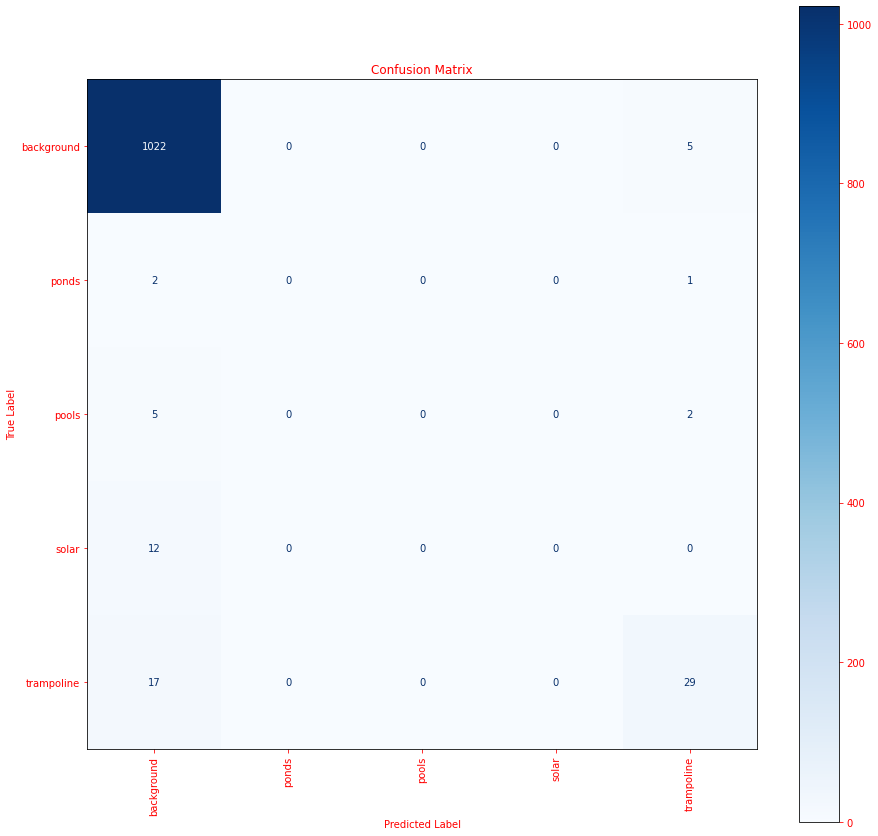

In [97]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

cm = confusion_matrix(y_val, predictions_val, labels=["background", "ponds", "pools", "solar", "trampoline"])

color = 'red'
fig, ax = plt.subplots(figsize=(15,15))
matrix = ConfusionMatrixDisplay.from_predictions(y_val, predictions_val, labels=["background", "ponds", "pools", "solar", "trampoline"], cmap=plt.cm.Blues, xticks_rotation='vertical', ax=ax)
matrix.ax_.set_title('Confusion Matrix', color=color)
plt.xlabel('Predicted Label', color=color)
plt.ylabel('True Label', color=color)
plt.gcf().axes[0].tick_params(colors=color)
plt.gcf().axes[1].tick_params(colors=color)
plt.show()

## Making predictions


In [98]:
from tensorflow import keras
from PIL import Image
from keras.applications.inception_v3 import preprocess_input
from keras import Model
import time
import pandas as pd

In [106]:
def makePredictions(path:str, convnet:keras.Model, stepSize:int, windowSize:tuple[int, int]):
    '''
    Traverses a folder that contains images for which predictions should be made.\n
    Creates a separate prediction CSV file for each image.

    @path - The path containing the images for which predictions should be created.
    '''

    # For each image in path
        # Perform sliding Window approach
            # For each slide
            # Store x_upper_left, y_upper_left, x_lower_right, y_lower_right
            # Run image through convnet
            # Run classifier on output
            # If prediction != 'background'
            # Store prediction in temp array
        # Run non-max suppression to filter predictions
        # Store predictions in csv
    for file in os.scandir(path):
        filepath = os.fsdecode(file)
        
        if(("annotated" in filepath) or not (filepath.endswith(".jpg") or filepath.endswith(".png"))):
           continue
        
        createPredictionsForImage(filepath=filepath, convnet=convnet, stepSize=stepSize, windowSize=windowSize)


def createPredictionsForImage(filepath:str, convnet:keras.Model, stepSize:int, windowSize:tuple[int,int]):
    '''
    Creates the prediction CSV for one image.
    '''

    print("\nCreating predictions for file: ", filepath)
    create_predictions_start_time = time.time()
    #image = Image.open(filepath)
    imgArray = np.array(Image.open(filepath))
    
    patch_coordinates= []  
    preprocessed_patches = []
    counter = 0
    patch_preprocessing_start_time = time.time()
    
    print("Starting sliding window to create patches of size: ", windowSize[0], "x", windowSize[1], ".")
    for(x,y,patch) in sliding_window(imageArray=imgArray, stepSize=stepSize, windowSize=windowSize):
        if counter > 0 and counter%10000 == 0:
            print("Still processing, reached patch", counter)
            print("Execution time for the last 10.000 patches: ", time.time()-patch_preprocessing_start_time, " seconds.")
            patch_preprocessing_start_time = time.time()
            print("Processing continues...")
        
        # Skip if the size of a patch doesn't match the specified windowSize
        if patch.shape[0] != windowSize[0] or patch.shape[1] != windowSize[1]:
            continue
    
        # Save coordinates which are needed for a prediction
        x_upper_left = x
        y_upper_left = y
        x_lower_right = x+windowSize[0]
        y_lower_right = y+windowSize[1]
        x_center = x+128
        y_center = y+128

        # Run the patch through the classification
        preprocessed_patch = preprocess_input(patch)
        preprocessed_patches.append(preprocessed_patch)
        patch_coordinates.append([y_upper_left, x_upper_left, y_lower_right, x_lower_right])
        counter +=1
    
    print("Finished preprocessing of the patches.")
    preprocessed_patches = np.array(preprocessed_patches)
    patch_coordinates = np.array(patch_coordinates)
    print("Shape of preprocessed patches: ", preprocessed_patches.shape)
    print("Shape of patch coordinates: ", patch_coordinates.shape, "\n")

    # Get all predictions
    print("Running patches through ConvNet and using classifier to predict labels...")
    prediction_start_time = time.time()
    predicted_labels_encoded = pd.DataFrame(convnet.predict(preprocessed_patches), columns=["background", "ponds", "pools", "solar", "trampoline"])
    predicted_labels= predicted_labels_encoded.idxmax(1)
    
    print("Finished predictions, execution time: ", time.time()-prediction_start_time, " seconds.\n")
    
    print("Shape of predicted_labels: ", labels.shape)
    print("Shape of patch_coordinates: ", patch_coordinates.shape)

    # Combining patch coordinates and predictions
    predictions_array=np.c_[predicted_labels, patch_coordinates]

    print("Shape of combined predictions array (unfiltered): ", predictions_array.shape)

    predictions_dataframe = pd.DataFrame(data=predictions_array, columns=["label", "y_upper_left", "x_upper_left", "y_lower_right", "x_lower_right"])
    # Filter all predictions that contain the label "background"
    predictions_dataframe = predictions_dataframe[predictions_dataframe.label != "background"]
    print("Description of the predictions dataframe: ", predictions_dataframe.describe())

    # Save prediction to csv
    savePredictionToCsv(predictionDataframe=predictions_dataframe, filepath=filepath)
    print("Saved predictions for file: ", filepath, "\n")
    print("Elapsed time: ", time.time()-create_predictions_start_time, " seconds.\n")

    
def sliding_window(imageArray, stepSize:int, windowSize:tuple[int, int]=(256,256)):
    for y in range(0, imageArray.shape[0], stepSize):
	    for x in range(0, imageArray.shape[1], stepSize):
			# yield the current window
		    yield (x, y, imageArray[y:y + windowSize[1], x:x + windowSize[0]])


In [107]:
import gc
preprocessed_patches = None
del preprocessed_patches
patch_coordinates = None
del patch_coordinates
X_train = None
del X_train
X_val = None 
del X_val
y_train = None
del y_train
y_val = None
training_data = None
del training_data
X_train_preprocessed = None
del X_train_preprocessed
gc.collect()

15380

In [108]:
makePredictions("./data/single_validation_image/", convnet=model, stepSize=64, windowSize=(256,256))



Creating predictions for file:  ./data/single_validation_image/DQIMQN.png
Starting sliding window to create patches of size:  256 x 256 .
Still processing, reached patch 10000
Execution time for the last 10.000 patches:  3.75296688079834  seconds.
Processing continues...
Finished preprocessing of the patches.
Shape of preprocessed patches:  (14884, 256, 256, 3)
Shape of patch coordinates:  (14884, 4) 

Running patches through ConvNet and using classifier to predict labels...
Finished predictions, execution time:  29.510068655014038  seconds.

Shape of predicted_labels:  (3316,)
Shape of patch_coordinates:  (14884, 4)
Shape of combined predictions array (unfiltered):  (14884, 5)
Description of the predictions dataframe:               label  y_upper_left  x_upper_left  y_lower_right  x_lower_right
count          126           126           126            126            126
unique           1            47            59             47             59
top     trampoline            64      

MemoryError: Unable to allocate 10.9 GiB for an array with shape (14884, 256, 256, 3) and data type float32

## Model Validation

This section contains code that is needed to create predictions, save them and to print the training / validation images - either with or without the predicted bounding boxes.

In [29]:
from PIL import Image
import matplotlib.pyplot as plt
import cv2 as cv
import pandas as pd
from pathlib import Path

In [35]:
def savePredictionToCsv(predictionDataframe: pd.DataFrame, filepath:str):
    '''
    Saves a dataframe containing the prediction for a single image to a CSV file.

    @predictionDataFrame - The dataframe that contains the predictions and should be saved.\n
    @path - The path under which the CSV file should be saved.
    @filename - The name under which the CSV file should be saved.
    '''
    filepath =  os.path.splitext(filepath)[0]+".csv"
    predictionDataframe.to_csv(filepath, sep=",", index=False)

def makeFakePredictions(path:str):
    '''
    Traverses a folder that contains images for which predictions should be made.\n
    Creates a separate prediction CSV file for each image.

    @path - The path containing the images for which predictions should be created.
    '''
    fake_predictions = {"label":["something"], "y_upper_left": [100], "x_upper_left":[100], "y_lower_right":[356], "x_lower_right":[356]}
    dataframe = pd.DataFrame(data=fake_predictions)
    counter = 0
    for file in os.scandir(path):
        filepath = os.fsdecode(file)

        if(not (filepath.endswith(".jpg") or filepath.endswith(".png")) or ("annotated" in filepath)):
            continue
        print("Making prediction for file: ", file.name) 
        savePredictionToCsv(dataframe, filepath)
        counter += 1
    print("Created ",counter, " predictions.")

def saveOrPrintImages(path:str, print_to_output:bool=False, valBoundingBoxes: bool = False, thickness: int = 2, saveImagesPath:str=""):
    '''
    Loads and saves all .jpg and .png files from the specified directory.\n

    @print - If set to True, will print the (annotated) images to the output (takes some time). Default value is False.

    @valBoundingBoxes If set to true, the method will load the bounding box data from the csv files. The default for this is False.\n
  
    @thickness parameter determines how thick the bounding boxes are drawn on the image (width of the line in pixels). The default value is 2.\n

    @saveImagesPath If specified will save the drawn images at the specified path.

    '''
    for file in os.scandir(path):
        filepath = os.fsdecode(file)
       

        if(not (filepath.endswith(".jpg") or filepath.endswith(".png"))  or ("annotated" in filepath)):
            continue

        print("Saving / printing file: ",os.path.splitext(file.name)[0],"_annotated.jpg")
        image = cv.imread(filepath) 
        
        if(valBoundingBoxes):
            image = addBoundingBoxesFromCsv(image, filepath, thickness)

        image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
        # Convert to PIL format
        image = Image.fromarray(image)
        if(saveImagesPath):
            image.save(saveImagesPath+"/"+ os.path.splitext(file.name)[0]+"_annotated.jpg", "JPEG")

        if(print_to_output):
            image.show()
        

def addBoundingBoxesFromCsv(image: cv.Mat, filepath:str, thickness: int) -> cv.Mat:
    '''
    Uses a csv file containing the predictions for a single image to draw bounding boxes into an image.\n

    Performs the changes in place and returns the modified image.
    The image parameter specifies the image to be modified.
    The filepath must contain the path of the csv file that contains the bounding box predictions for this image.
    '''
    csvPath = os.path.splitext(filepath)[0]+".csv"
    boundingBoxesDataframe = pd.read_csv(csvPath, delimiter=",", header=0 )

    for index,boundingBox in boundingBoxesDataframe.iterrows():
        label = boundingBox[0]
        start_point = (boundingBox["x_upper_left"],boundingBox["y_upper_left"])
        end_point = (boundingBox["x_lower_right"], boundingBox["y_lower_right"])

        color:str
        
        if(label== "background"):
            color=(255,255,255) # (BGR) White
        elif(label == "pool"):
            color=(255,255,0) # (BGR) Cyan
        elif(label == "pond"):
            color=(0,128,0) # (BGR) Green
        elif(label == "solar"):
            color=(255,0,0) # (BGR) Blue
        elif(label == "trampoline"):
            color=(0,255,255) # (BGR) Yellow
        else:
            color=(180,105,255) # (BGR) Pink if no label present
        image = cv.rectangle(image, start_point, end_point, color, thickness=thickness)
    
    return image

### Model Validation (Custom Model)

In [36]:
saveOrPrintImages(path="./data/single_validation_image/", print_to_output=False, valBoundingBoxes=True,saveImagesPath="./data/single_validation_image/", thickness=5)

Saving / printing file:  DQIMQN _annotated.jpg


### Model Validation (Unlabeled Training Data)

This section prints the unlabeled training images along with bounding boxes that are retrieved from the corresponding CSV files.

In [7]:
makeFakePredictions(path="./data/unlabeled_training_data/")
saveOrPrintImages(path="./data/unlabeled_training_data/", print_to_output=False, valBoundingBoxes=True,saveImagesPath="./data/unlabeled_training_data/", thickness=5)

Making prediction for file:  0FRGJD.png
Making prediction for file:  3938J9.png
Making prediction for file:  6ATLJM.png
Making prediction for file:  6FPS9I.png
Making prediction for file:  73COYK.png
Making prediction for file:  9Q69FH.png
Making prediction for file:  B7DBOX.png
Making prediction for file:  BFVATM.png
Making prediction for file:  CM380U.png
Making prediction for file:  DHX1Z3.png
Making prediction for file:  FML5SH.png
Making prediction for file:  G8MS91.png
Making prediction for file:  JBN1LY.png
Making prediction for file:  NNP6V0.png
Making prediction for file:  P5L1VO.png
Making prediction for file:  RXRIIW.png
Making prediction for file:  S9CT2G.png
Making prediction for file:  W0E9JC.png
Making prediction for file:  W4XC08.png
Making prediction for file:  XRZXKK.png
Created  20  predictions.
Saving / printing file:  0FRGJD _annotated.jpg
Saving / printing file:  3938J9 _annotated.jpg
Saving / printing file:  6ATLJM _annotated.jpg
Saving / printing file:  6FPS9I _

## Printing the validation images

This section prints the public test data images along with their respective predictions / bounding boxes.

In [9]:
# Print images from the validation data and use the corresponding csv files to add bounding boxes of classified entities
saveOrPrintImages("data/validation_data/", print_to_output=False, valBoundingBoxes=True, thickness=5, saveImagesPath="./data/validation_data/")

Saving / printing file:  DQIMQN _annotated.jpg
Saving / printing file:  L7CT2I _annotated.jpg
Saving / printing file:  UDPYYD _annotated.jpg
